In [31]:
import json
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
from utils.molecule_tools import get_molecule
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
import numpy as np
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP

In [32]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

JSONDecodeError: Expecting property name enclosed in double quotes: line 41535 column 5 (char 1694745)

In [3]:
speciesname = "C_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']

print(num_qubits)

5


C_STO-3G_SINGLET reaches chemical accuracy for 4-qubit CS-VQE


/home/ucaptwe/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1266: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


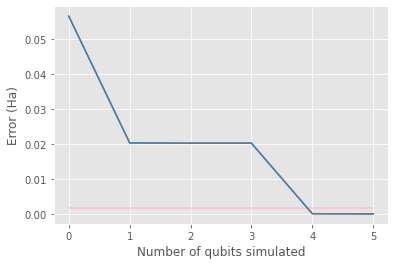

In [4]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

In [5]:
anz_ops = mol_circ.sufficient_anz_terms(uccsd)

Testing operator 1/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...


/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


Testing operator 2/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 3/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 4/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 5/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 6/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 7/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 8/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 9/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 10/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 11/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 12/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 1

Testing operator 108/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 109/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 110/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 111/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 112/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 113/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 114/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 115/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 116/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 117/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 118/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...

Testing operator 93/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 94/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 96/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 97/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 98/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 102/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 103/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 105/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 106/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 107/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 108/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Test

Testing operator 78/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 79/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 81/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 82/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 85/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 88/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 89/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 90/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 92/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 93/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 94/120
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing op

In [6]:
print(anz_ops)

['ZYXII', 'XIIXX', 'ZXYII']


4-qubit reduced Hamiltonian: {'IIII': -30.925064807161768, 'ZZII': 0.35989787940568607, 'IZZI': 0.005379508010191029, 'ZIZI': -0.032711314716613385, 'IIZZ': -0.0053795080101929375, 'ZZZZ': 0.03271131471660958, 'IZIZ': -0.2558386160401826, 'ZIIZ': -0.1914418116527673, 'IIIZ': 0.16095608172838227, 'ZZIZ': 0.27397293771233117, 'IZZZ': 0.03271131524363324, 'ZIZZ': -0.005379507483169479, 'IIZI': -0.03271131524363437, 'ZZZI': 0.005379507483169118, 'IZII': 0.4206367623119874, 'ZIII': 5.294110785096679, 'XZII': -5.888319067082067e-10, 'YIII': 0.007268808629597214, 'XIZI': -3.9304913707150154e-27, 'YZZI': 0.0, 'XZZZ': 3.9304913707150154e-27, 'YIZZ': 0.0, 'XIIZ': 5.93374786042067e-27, 'YZIZ': 0.007268809019637259, 'YZII': -0.007268808629597214, 'XIII': 5.888319067082067e-10, 'YIZI': -9.864238762411521e-27, 'XZZI': 5.93374786042067e-27, 'YZZZ': 1.7725221503841553e-26, 'XIZZ': -9.864239231778595e-27, 'YIIZ': -0.007268809019637259, 'XZIZ': 1.1791474112145046e-26, 'YYZI': -5.888319067082067e-10, 'XX

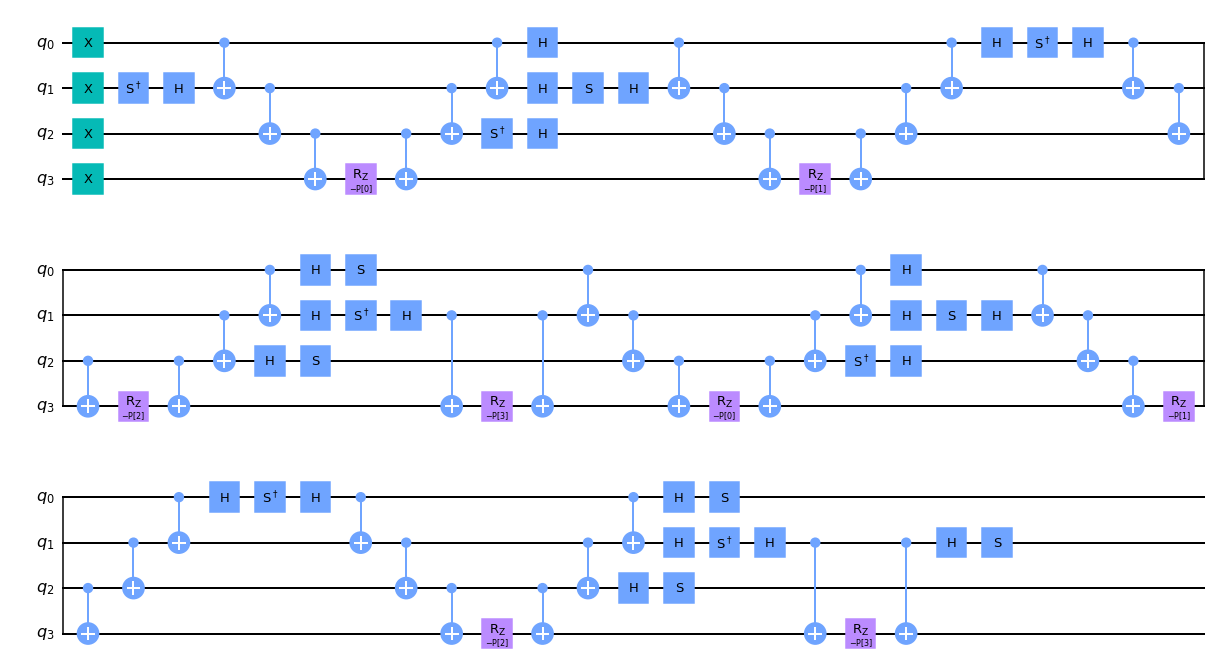

In [11]:
#import random
ham_red = mol_circ.ham_reduced[num_sim_q]
#anz_indices = [random.randint(0, len(uccsd.keys())) for i in range(1)]
#print(anz_indices)
#for B+  anz_ops = ['ZYIXX', 'XZIXX']
#for Be anz_ops = ['ZYZXX', 'IIYXX', 'XIIYX', 'IYZXX']
#for C anz_ops = ['ZXYII', 'XZZXX', 'XIZYX']
#for LiH anz_ops = ['YXIIIIXX', 'IIIIIYZX', 'IIIIYXYY', 'XZIIZYIY', 'IIIIXZYI', 'XXIIIIYX', 'IIIIXXXY', 'IXIIXIIY', 'IYIIXIIY', 'IYIIZZZX', 'IIIIXXYX']
#for HF  anz_ops = ['XYIIXXII', 'XYIIIIXX', 'IYIIZXII', 'YYIIZZYX', 'IYIIZZZX', 'YYIIIIYX', 'XXIIYXII', 'YXIIYYII']
#anz_indices = [49, 97, 71, 72] #for C
#anz = {op:uccsd[op] for op in [list(uccsd.keys())[i] for i in anz_indices]}
#anz = uccsd
#anz_ops = ['ZXIYX', 'XZZXX', 'YZZXX']
anz = {op:uccsd[op] for op in anz_ops}

anz_red = mol_circ.project_anz_terms_alt(anz_terms=anz, num_sim_q = num_sim_q)
ham_red = mol_circ.ham_reduced[num_sim_q]
qc = mol_circ.build_circuit(anz, num_sim_q)
init_params = mol_circ.init_param
bounds = np.array([(p-np.pi, p+np.pi) for p in init_params])
qc.parameter_bounds = bounds

print('%i-qubit reduced Hamiltonian:'%num_sim_q, ham_red, '\n')
print('%i-qubit reduced Ansatz:'%num_sim_q, anz_red, '\n')
print('Corresponding reduced Ansatz circuit:')
qc.draw(output='mpl')

In [8]:
len(mol_circ.init_param)

4

# Performing the simulation *without* noise

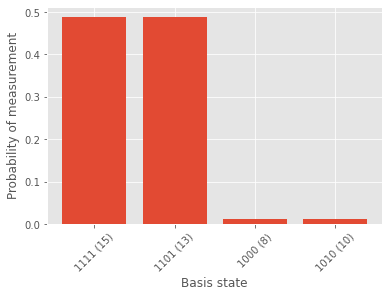

*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...


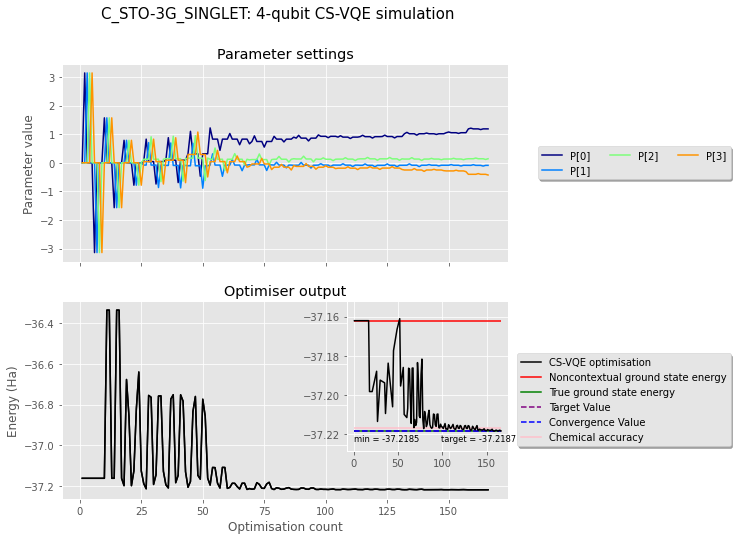

In [9]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=anz, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=IMFIL(maxiter=10000), 
                                 param_bound=np.pi,
                                 noise=False,
                                show_amps=True)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

In [49]:
param_hist = [config for param, config in cs_vqe_results['params'].items()]
init_params = np.array(list(zip(*param_hist))[-1])

In [12]:
init_params

array([-4.33680869e-19,  3.82150000e-19,  2.05037738e-19, -4.33680869e-19])

# Performing the simulation *with* noise

The noise model used below emulates IBM's 5-qubit Vigo device, derived from real-life performance data

In [13]:
import os
from qiskit.algorithms import VQE
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo, FakeTenerife, FakeMelbourne, FakeRueschlikon, FakeTokyo
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, TensoredMeasFitter

In [14]:
def get_quantum_instance(seed, noise=False, error_mitigation=None):
    algorithm_globals.random_seed = seed
    
    if not noise:
        backend = Aer.get_backend('statevector_simulator')
        qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    
    else:
        device_backend = FakeRueschlikon()
        backend = Aer.get_backend('aer_simulator')
        noise_model = None
        device = QasmSimulator.from_backend(device_backend)
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        basis_gates = noise_model.basis_gates
        
        qi = QuantumInstance(backend=backend,
                             shots=2**10,
                             seed_simulator=seed, 
                             seed_transpiler=seed,
                             coupling_map=coupling_map, 
                             noise_model=noise_model,
                             measurement_error_mitigation_cls=error_mitigation,
                             measurement_error_mitigation_shots=2**10,
                             cals_matrix_refresh_period=30)
        
    return qi

In [15]:
def vqe_simulation(ansatz, operator, init_params, noise=False, error_mitigation=None):
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        """ Outputs intermediate data during VQE routine
        """
        counts.append(eval_count)
        prmset.append(parameters)
        values.append(mean)
        errors.append(std)
    
    counts=[]
    prmset=[]
    values=[]
    errors=[]
    
    qi = get_quantum_instance(seed=42, noise=noise, error_mitigation=error_mitigation)
    vqe = VQE(ansatz, 
              initial_point=init_params, 
              optimizer=IMFIL(maxiter=1000), 
              callback=store_intermediate_result, 
              quantum_instance=qi) 
    vqe_input_op = qonvert.dict_to_WeightedPauliOperator(operator)
    vqe_run = vqe.compute_minimum_eigenvalue(operator=vqe_input_op)
    
    return {'conval':vqe_run.optimal_value,
            'counts':counts,
            'prmset':prmset,
            'values':values,
            'errors':errors}

Noiseless VQE error: 0.00011890722586826996
Noisy VQE error: -0.001223214315722032
Noisy VQE with error mitigation error: 0.05530805018760532


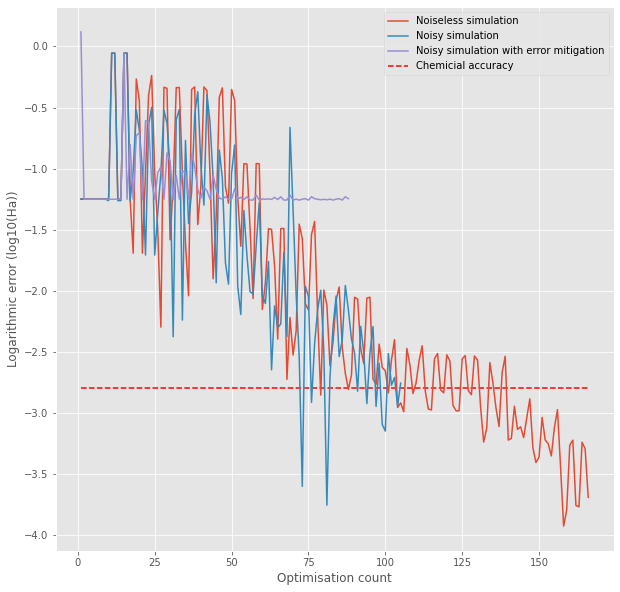

In [16]:
noiseless        = vqe_simulation(ansatz=qc, 
                                  operator=ham_red, 
                                  init_params=init_params, 
                                  noise=False, 
                                  error_mitigation=None)
print('Noiseless VQE error:', noiseless['conval']-mol_circ.true_gs)

noisy            = vqe_simulation(ansatz=qc, 
                                operator=ham_red, 
                                init_params=init_params, 
                                noise=True, 
                                error_mitigation=None)
print('Noisy VQE error:', noisy['conval']-mol_circ.true_gs)

noisy_mitigation = vqe_simulation(ansatz=qc, 
                                operator=ham_red, 
                                init_params=init_params, 
                                noise=True, 
                                error_mitigation=CompleteMeasFitter)#TensoredMeasFitter)
print('Noisy VQE with error mitigation error:', noisy_mitigation['conval']-mol_circ.true_gs)

x_lim = max([noiseless['counts'][-1], noisy['counts'][-1], noisy_mitigation['counts'][-1]])

fig, ax = plt.subplots(figsize=(10,10))

#ax.hlines(mol_circ.true_gs, 1, x_lim, color='g', label='True ground state energy', ls='--')
#ax.hlines(mol_circ.true_gs+0.0016, 1, x_lim, color='pink', label='Chemical accuracy', ls='--')
#ax.hlines(mol_circ.gs_noncon_energy, 1, x_lim, color='red', label='Noncon gs energy', ls='--')
ax.hlines(np.log10(0.0016), 1, x_lim, color='red', label='Chemicial accuracy', ls='--')

ax.plot(noiseless['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noiseless['values']], label='Noiseless simulation')
ax.plot(noisy['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noisy['values']], label='Noisy simulation')
ax.plot(noisy_mitigation['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noisy_mitigation['values']], label='Noisy simulation with error mitigation')

ax.set_xlabel('Optimisation count')
ax.set_ylabel('Logarithmic error (log10(Ha))')
ax.legend()

In [18]:
from qiskit import IBMQ

with open('data/token.txt', 'r') as file:
    TOKEN = file.read()

IBMQ.save_account(TOKEN, overwrite=True)

In [19]:
IBMQ.load_account()

/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [20]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_manila')

In [21]:
backend.name()

'ibmq_manila'

In [22]:
from qiskit_nature.runtime import VQEProgram

In [23]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [24]:
# currently the VQEProgram supports only 'SPSA' and 'QN-SPSA'
optimizer = {
    'name': 'QN-SPSA',  # leverage the Quantum Natural SPSA
    # 'name': 'SPSA',  # set to ordinary SPSA
    'maxiter': 100,
    'resamplings': {1: 100},  # 100 samples of the QFI for the first step, then 1 sample per step
}

runtime_vqe = VQEProgram(ansatz=qc,
                         optimizer=optimizer,
                         initial_point=init_params,
                         provider=provider,
                         backend=backend,
                         shots=1024,
                         measurement_error_mitigation=True,
                         callback=callback)  # use a complete measurement fitter for error mitigation

In [25]:
vqe_input_op = qonvert.dict_to_WeightedPauliOperator(ham_red)
runtime_result = runtime_vqe.compute_minimum_eigenvalue(vqe_input_op)

/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
runtime_job._start_websocket_client:WARNING:1970-01-01 05:27:37,949: An error occurred while streaming results from the server for job c5ompb2kh8krlc7cvah0:
Traceback (most recent call last):
  File "/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 325, in _start_websocket_client
    self._ws_client.job_results()
  File "/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/runtime_ws.py", line 74, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/base.py", line 211, in stream
    raise WebsocketError(error_message)
qiskit.providers.ibmq.api.exceptions.Websocke

In [26]:
intermediate_info

{'nfev': [], 'parameters': [], 'energy': [], 'stddev': []}

In [27]:
runtime_result.eigenvalue

(-32.6787413160546+0j)

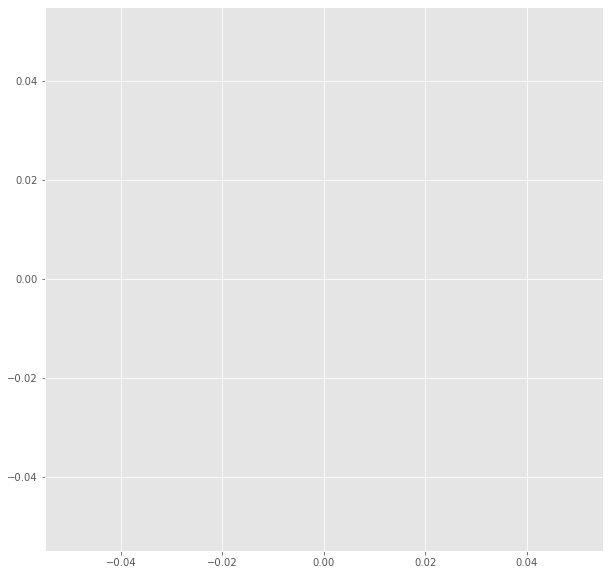

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(intermediate_info['nfev'], intermediate_info['energy'])

In [ ]:
#import json 

#data={}
#for k in intermediate_info.keys():
#    data[str(k)] = intermediate_info[k]

#data['parameters'] = [list(t) for t in data['parameters']]
#data['stddev'] = [t.real for t in data['stddev']]

#with open("data/IBMQ-runtime/"+speciesname+"_UCCSD_taper_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
#    json.dump(data, outfile)

In [29]:
intermediate_info['nfev'] = list(range(len(runtime_result.optimizer_history['loss'])))
intermediate_info['energy'] = runtime_result.optimizer_history['loss']
intermediate_info['parameters'] = runtime_result.optimizer_history['params']

parameters={}
for index, param in enumerate([p.name for p in list(qc.parameters)]):
    parameters[param] = list(zip(*intermediate_info['parameters']))[index]
    
data={'counts':intermediate_info['nfev'],
      'values':intermediate_info['energy'],
      'params':parameters,
      'errors':[t.real for t in intermediate_info['stddev']],
      'true_gs':mol_circ.true_gs,
      'result':runtime_result.optimal_value,
      'target':mol_circ.cs_vqe_energy[num_sim_q],
      'gs_noncon_energy':mol_circ.gs_noncon_energy,
      'optimiser':optimizer['name'],
      'backend':backend.name()}

In [68]:
import json 

with open("data/IBMQ-runtime/"+speciesname+"_UCCSD_taper_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
    json.dump(data, outfile)

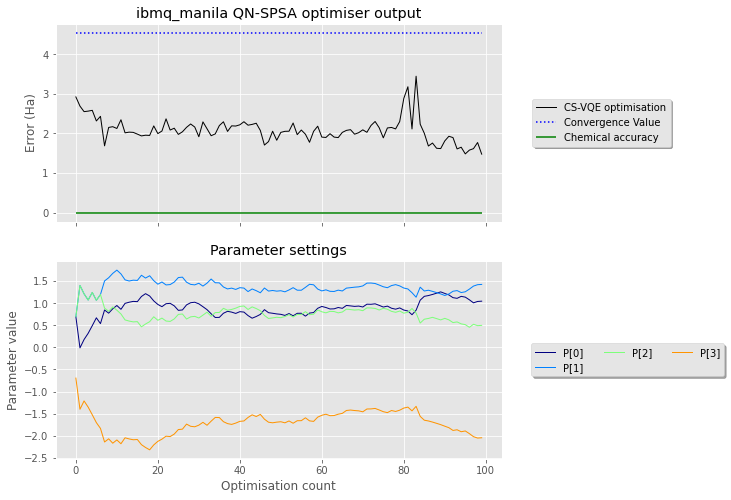

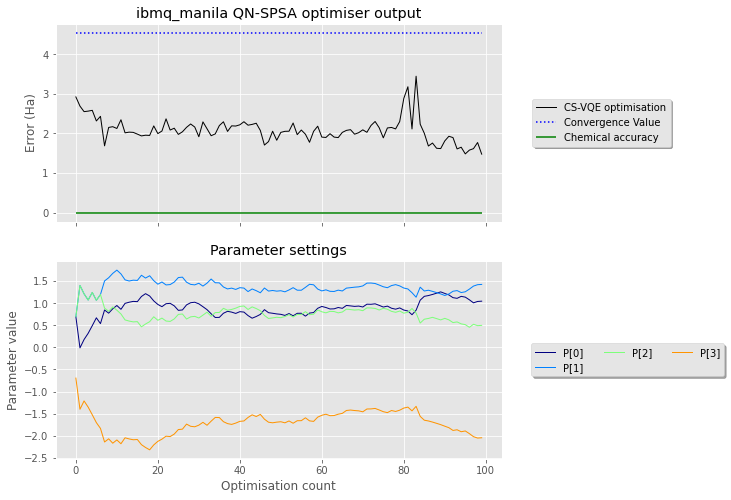

In [30]:
plot.plot_parameter_settings_alt(data)

In [ ]:
test = np.array([])

In [ ]:
test = np.append(test, 3)
test

In [ ]:
np.delete(test, test)